In [ ]:
!pip install -q seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
from google.colab import files
uploaded = files.upload()



Saving online+retail.zip to online+retail.zip


In [ ]:
import zipfile

with zipfile.ZipFile('online+retail.zip', 'r') as zip_ref:
    zip_ref.extractall()


In [ ]:
import os
os.listdir()


['.config', 'online+retail.zip', 'Online Retail.xlsx', 'sample_data']

In [ ]:
df = pd.read_excel('Online Retail.xlsx')


In [ ]:
df.info()

print(df.isnull().sum())

df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [ ]:
# Droping rows with missing CustomerID:
df = df.dropna(subset=['CustomerID'])

In [ ]:
# Removing negative or zero quantity values:
df = df[df['Quantity'] > 0]

In [ ]:
df.reset_index(drop=True, inplace=True)

In [ ]:
# 1 day the last inovice for recency:
reference_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)


In [ ]:
# Creating the RFM values for each customer to understand customer behavior:
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'UnitPrice': lambda x: (x * df.loc[x.index, 'Quantity']).sum()
})
rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'UnitPrice': 'Monetary'
}, inplace=True)
# Removing customer with 0 monetary value:
rfm = rfm[rfm['Monetary'] > 0]
rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,7,4310.00
12348.0,75,4,1797.24
12349.0,19,1,1757.55
12350.0,310,1,334.40


In [ ]:
# Clustering based on RFM values to identify groups of customers with similar behavior:

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
rfm_scaled =scaler.fit_transform(rfm)


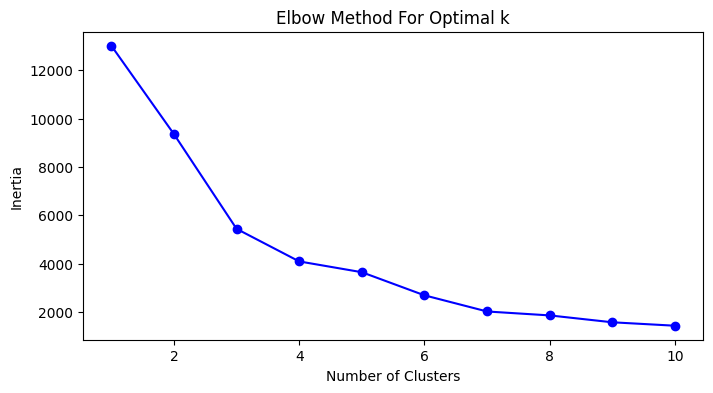

In [ ]:
# Decide how many customer segments to create:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
inertia = []
K = range(1, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)
plt.figure(figsize=(8, 4))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()


In [ ]:
# Apply KMeans with your chosen number of clusters:
# Example,if elbow point is 6:

kmeans = KMeans(n_clusters=6, random_state=30)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)
# View's average RFM values per cluster
rfm.groupby('Cluster').mean()


,Recency,Frequency,Monetary
Cluster,,,
0,35.346805,3.469977,1270.903850
1,6.700000,75.200000,60460.451000
2,294.418269,1.301282,600.352260
3,3.000000,45.500000,225721.652500
4,155.390244,2.101412,698.967742
5,14.952077,17.204473,8237.662588


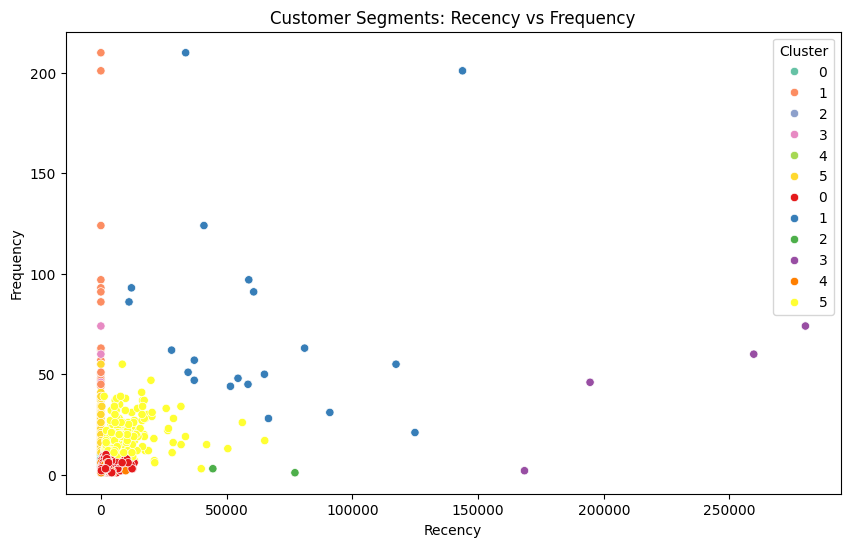

In [ ]:
# Visualize Clusters:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.scatterplot(data=rfm, x='Recency', y='Frequency', hue='Cluster', palette='Set2')
plt.title('Customer Segments: Recency vs Frequency')
sns.scatterplot(data=rfm, x='Monetary', y='Frequency', hue='Cluster', palette='Set1')

plt.show()


In [ ]:
rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean'
}).assign(NumCustomers = rfm.groupby('Cluster').size())




,Recency,Frequency,Monetary,NumCustomers
Cluster,,,,
0,35.346805,3.469977,1270.903850,2598
1,6.700000,75.200000,60460.451000,20
2,294.418269,1.301282,600.352260,624
3,3.000000,45.500000,225721.652500,4
4,155.390244,2.101412,698.967742,779
5,14.952077,17.204473,8237.662588,313


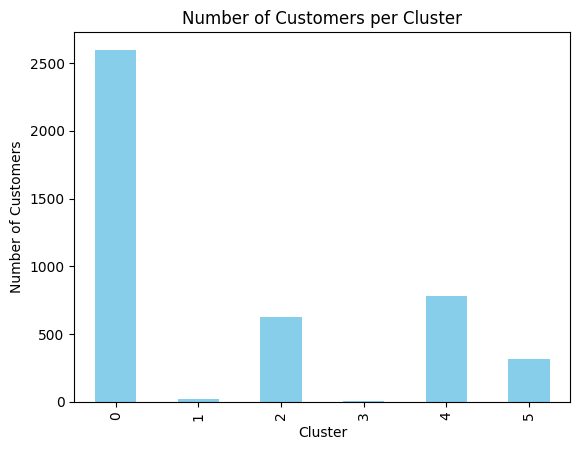

In [ ]:
rfm['Cluster'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Number of Customers per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Customers')
plt.show()
